# Indentifying Stress Factors in Rainbow Trouts

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [2]:
from sklearn.decomposition import KernelPCA, PCA

## Data - USDA
Performing basic cleanup and organization.
* Fishes belonging to the following categories: Control(con), Crowded(cro), High Salinity(hs), High temperature(ht), Low Temperature(lt) and Reused Water(rw).
* The dataset was transposed and renamed to become organized.
* The columns are the transcripts obtained from the fish. The prefix is the gene whereas, the suffix is the transcript number.

In [35]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
data = pd.read_excel(dataPath)

data.columns = columns
data = data.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
data = data.assign(tank = tankColums)

print(data.shape)
data.head()

(40, 125909)
CPU times: user 21.3 s, sys: 279 ms, total: 21.6 s
Wall time: 21.6 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [36]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, con0 to rw5
Columns: 125909 entries, 4ebp2_1 to tank
dtypes: float64(125908), object(1)
memory usage: 38.4 MB


In [37]:
data.head()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [38]:
cols = data.columns.tolist()

geneCounter = {}

for gen in [i.split('_')[0] for i in cols]:
    geneCounter[gen] = geneCounter.get(gen, 0)+1
# geneCounter

print(f"There are {len(cols)} transcripts, and {len(geneCounter)} unique genes.\nThere are{len(cols)/len(geneCounter): .2f} Transcripts per gene on on average.")

There are 125909 transcripts, and 57615 unique genes.
There are 2.19 Transcripts per gene on on average.


In [39]:
print(data.shape)

(40, 125909)


Primary Data Analysis Observations:
* The distribution of rows are as such: 10 rows in Control. 6 in the remaining.
* Clearly, we have a lot of columns in comparison on the number of rows.
* The number of columns are 125908 and the number of rows are 40.
* This is a typical high dimensional p>n problem.

## Dimensionality Reduction 

In [47]:
# Removing columns with mean 0
meanZeroCols = data.iloc[:,:-1].mean() == 0

meanZeroCols = meanZeroCols[meanZeroCols==True].index.tolist()
print(f"Number of columns with just 0: {len(meanZeroCols)}\nTotal Number of columns: {data.shape[1]}")
print(f"This is {(len(meanZeroCols)/data.shape[1])*100: .2f}% of all columns")
# data[meanZeroCols].mean()

Number of columns with just 0: 30013
Total Number of columns: 125909
This is  23.84% of all columns


In [53]:
data = data.loc[:, (data!=0).any(axis=0)]
data.head()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_6,aakb1_7,aakb1_8,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.000000,0.0,5.631537,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.000000,0.0,6.048805,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,4.817612,0.0,7.248526,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.000000,0.0,7.837344,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.000000,0.0,5.786782,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [54]:
# kpca = KernelPCA(kernel='linear')
pca = PCA()

In [55]:
%%time
pcaData = data.iloc[:, :-1]
pca.fit(pcaData)

CPU times: user 2.43 s, sys: 43.8 ms, total: 2.47 s
Wall time: 506 ms


PCA()

In [56]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

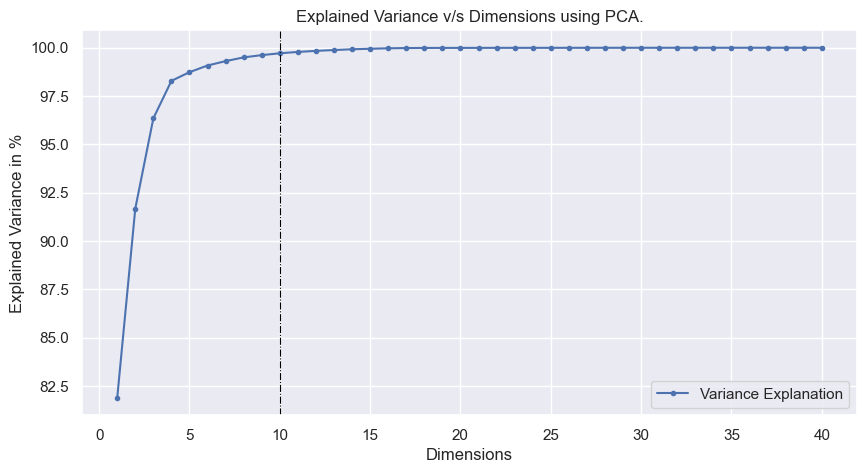

In [58]:
plt.figure(figsize=(10,5), dpi = 100)
plt.plot(range(1, len(cumsum)+1),cumsum*100,'.-', label='Variance Explanation')
plt.legend()
plt.axvline(10, ls='-.', c='black', lw=0.8)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance in %")
plt.title("Explained Variance v/s Dimensions using PCA.")
plt.show()

What the above plot is saying that, statistically, the entire dataset with 125908 columns, can be represented in the form of around 10 dimensions.

## Exploratory Data Analysis

In [59]:
data.groupby('tank').sum()#.plot()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_6,aakb1_7,aakb1_8,...,zwilch_1,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3
tank,,,,,,,,,,,,,,,,,,,,,
con,242.373432,336.559280,28.078077,22.697418,10.764145,30.569819,483.181415,8.845572,0.000000,52.860393,...,0.000000,4.874443,4.431331,4.605613,174.784106,77.099398,183.443888,9.157897,9.235417,9.037803
cro,164.556883,160.440878,17.679199,17.050463,7.105580,18.943720,311.843118,0.000000,0.000000,39.656491,...,0.000000,2.671778,3.563159,3.857359,107.300893,40.665702,99.988293,4.843522,4.810430,5.061424
hs,23.639558,57.961725,2.448351,1.304311,1.136457,2.495911,39.851309,0.678986,0.009943,5.451092,...,0.000000,0.358625,0.514305,0.522865,13.558132,8.255980,15.691567,1.173979,1.176177,1.178490
ht,124.767550,210.558756,13.949381,7.825844,4.712404,18.549925,246.768281,12.987430,0.309918,25.682433,...,0.005296,1.812479,2.016376,1.723104,87.021717,61.775730,142.651117,6.309693,6.539187,6.528933
lt,158.386886,171.564422,19.254322,13.900509,9.778003,17.899788,312.819083,16.642308,0.158853,19.958375,...,0.000000,3.849873,3.087986,3.159195,101.663390,37.339355,86.270179,4.406879,4.648242,4.662207
rw,153.089798,210.944561,13.079132,13.635740,6.596914,17.518561,284.277129,14.794088,0.206478,16.949882,...,0.000000,2.190003,3.116978,3.299554,112.278281,40.915950,82.027141,4.662268,4.521860,4.613485


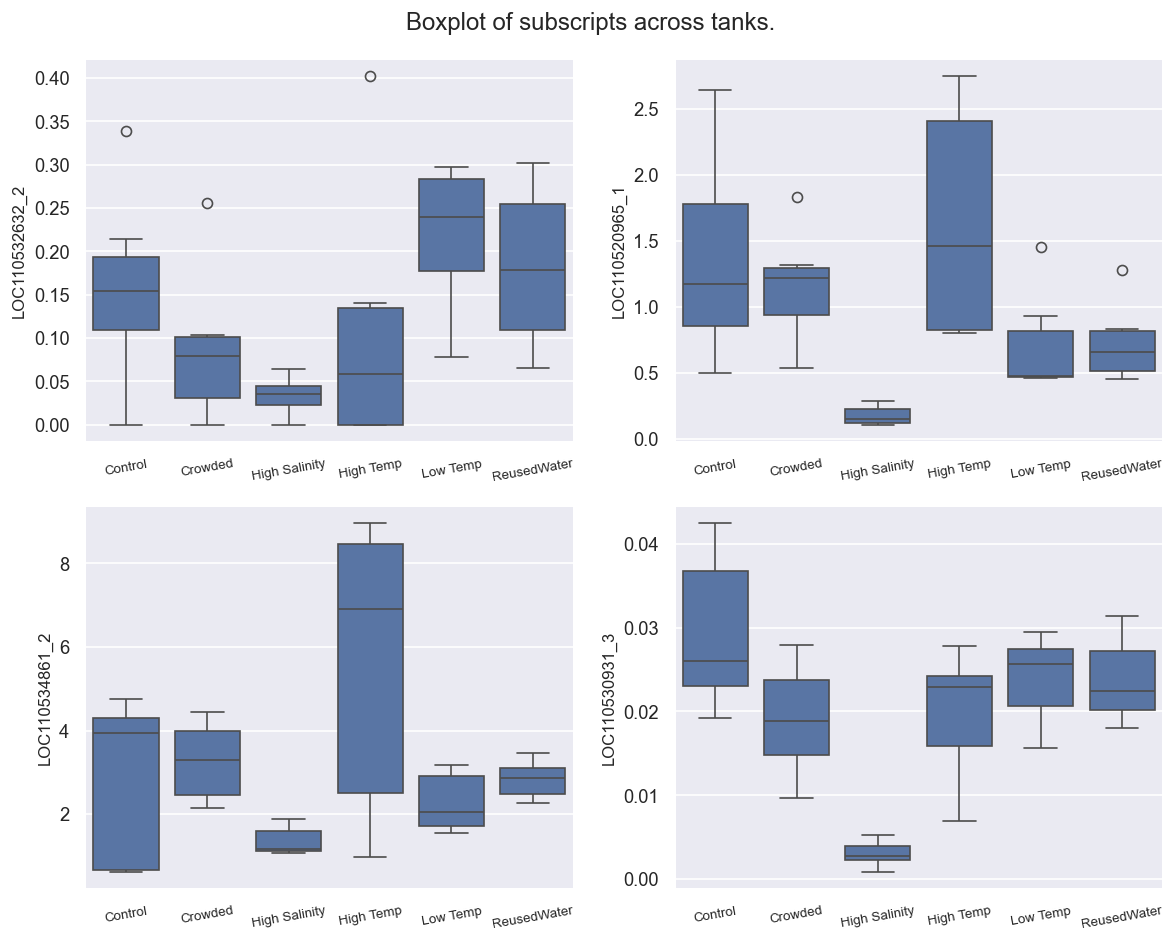

In [193]:
# plt.figure(figsize=(10,6), dpi=100)

nrows, ncols = 2,2
# boxplotCols = np.random.choice(data.columns, size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8), dpi = 120, squeeze=True)

fig.suptitle("Boxplot of subscripts across tanks.")
for r in range(nrows):
    for c in range(ncols):
        idxName = boxplotCols[r][c]
        tempData = data.loc[:, ['tank', idxName]]
        sns.boxplot(data=tempData, x='tank', y=idxName, ax=ax[r][c], showfliers=True)
        # sns.boxplot(data=tempData, hue='tank', y=idxName, ax=ax[r][c], palette='rocket')
        ax[r][c].set_ylabel(idxName, fontsize=10)
        ax[r][c].set_xlabel(None, fontsize=10)
        ax[r][c].set_xticks(range(6), labels=['Control', 'Crowded', 'High Salinity', 'High Temp', 'Low Temp', 'ReusedWater'],fontsize=8, rotation=10)
        # ax[r][c].set_xticklabels(rotation=20) 

plt.tight_layout()
plt.show()

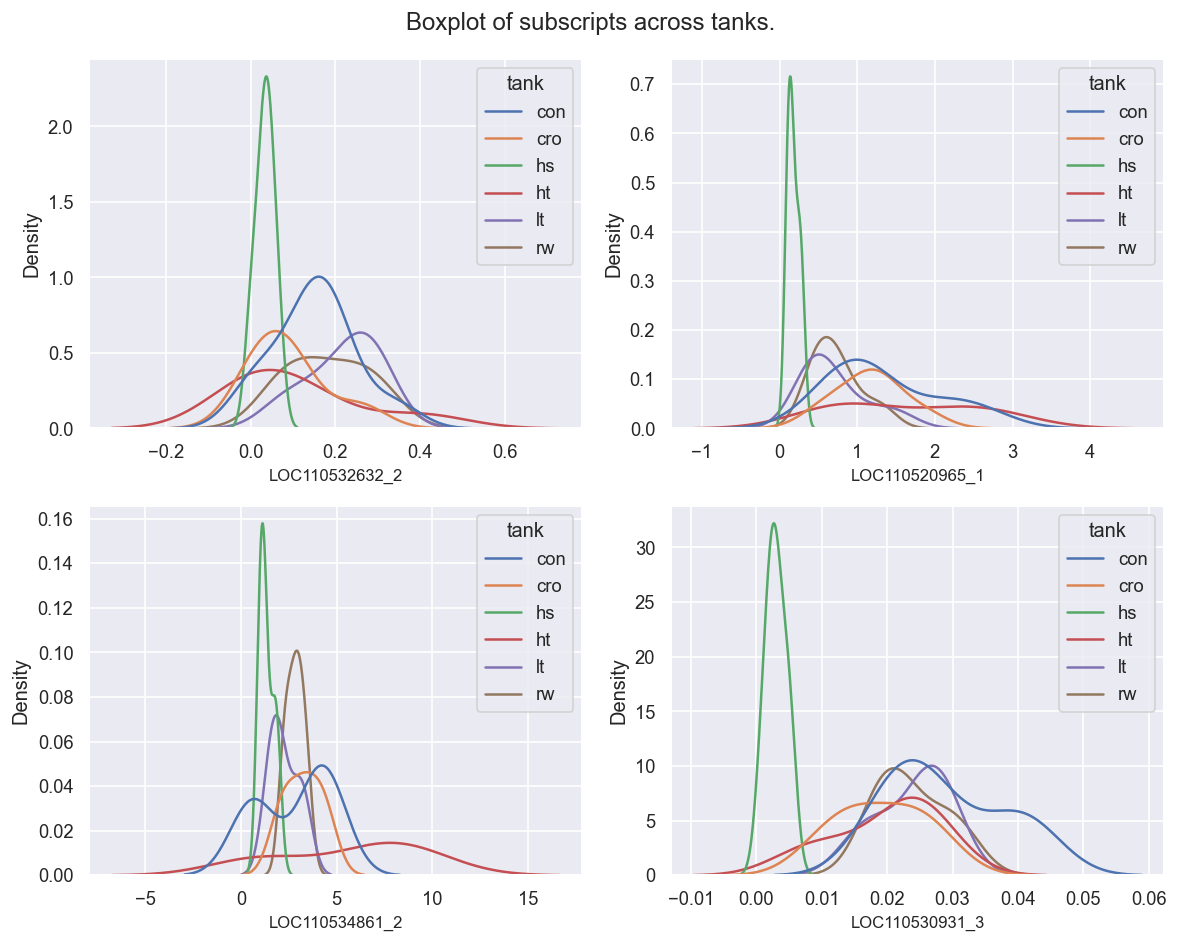

In [210]:
# plt.figure(figsize=(10,6), dpi=100)

nrows, ncols = 2,2
# boxplotCols = np.random.choice(data.columns, size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8), dpi = 120, squeeze=True)

fig.suptitle("Distribution of subscripts across tanks.")
for r in range(nrows):
    for c in range(ncols):
        idxName = boxplotCols[r][c]
        tempData = data.loc[:, ['tank', idxName]]
        sns.kdeplot(data=tempData,x=idxName, hue='tank', ax=ax[r][c])
        # sns.boxplot(data=tempData, hue='tank', y=idxName, ax=ax[r][c], palette='rocket')
        # ax[r][c].set_ylabel(idxName, fontsize=10)
        ax[r][c].set_xlabel(idxName, fontsize=10)
        # ax[r][c].set_xticks(range(6), labels=['Control', 'Crowded', 'High Salinity', 'High Temp', 'Low Temp', 'ReusedWater'],fontsize=8, rotation=10)
        # ax[r][c].set_xticklabels(rotation=20) 

plt.tight_layout()
plt.show()

In [186]:
# This shows that we have a certain columns with several outliers.
def findOutliersFnx(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return len(s[s<m])

In [189]:
%%time
colOutliersCount = data.iloc[:,:-1].apply(findOutliersFnx,m=3., axis=0)

CPU times: user 10 s, sys: 52.8 ms, total: 10.1 s
Wall time: 10.1 s


In [ ]:
# sns.barplot(colOutliersCount)

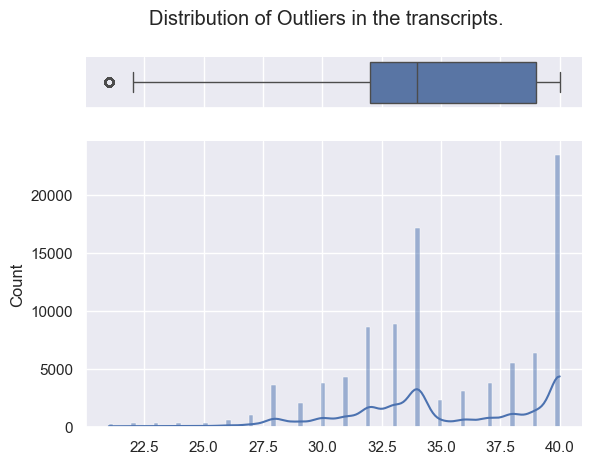

In [221]:
# sns.boxplot(colOutliersCount)

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(colOutliersCount, ax=ax_box, orient='h')
sns.histplot(colOutliersCount,bins=100, kde=True, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of Outliers in the transcripts.")
plt.show()

---

In [6]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
data = pd.read_excel(dataPath)

# colsTemp = ['idx']+['CTRL']*(data.shape[1]//2)+['HEAT']*(data.shape[1]//2)

# data.columns = colsTemp
# data.iloc[0,0] = 'DAY'

# data = data.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)

# print(data.shape)

CPU times: user 20.9 s, sys: 221 ms, total: 21.1 s
Wall time: 21.1 s


In [106]:
data.groupby(['GeneExp','DAY']).mean()

idx                 4ebp2      5ntc      aacs     aadac   aadacl4     aagab  \
GeneExp DAY                                                                   
CTRL    Day 1   23.988963  6.649193  2.743176   1.42256  0.831154   2.44779   
        Day 28   20.98674   6.70786  3.666843  3.226702  2.633585  3.784658   
        Day 3   20.728252  5.598291  2.278286  1.258414  0.618164   2.41489   
        Day 7   22.401635  5.411027  2.208981  1.257053   0.61616  2.121508   
HEAT    Day 1   15.156847  6.011973  2.715426  1.344798  0.894721  2.204399   
        Day 28  23.872175  4.363281  4.056534  2.722479  2.896642  3.210366   
        Day 3   25.324825  3.356996  2.150928  0.967521  0.308134  2.162818   
        Day 7   26.806386   4.59414  3.527078  2.099082  1.415532   2.64552   

idx               aakb1_1 aakb1_2 aakb1_3 aakb1_4  ... abcg2b_4  abcg4a_1  \
GeneExp DAY                                        ...                      
CTRL    Day 1   31.976836     0.0     0.0     0.0  ...      0.0  0.851713   
        Day 28  22.885776     0.0     0.0     0.0  ...      0.0  0.787979   
        Day 3   37.515633     0.0     0.0     0.0  ...      0.0  0.795323   
        Day 7   34.870403     0.0     0.0     0.0  ...      0.0  0.693923   
HEAT    Day 1    14.07099     0.0     0.0     0.0  ...      0.0  0.578758   
        Day 28  23.349669     0.0     0.0     0.0  ...      0.0  0.355181   
        Day 3   21.873905     0.0     0.0     0.0  ...      0.0  0.206124   
        Day 7   24.269232     0.0     0.0     0.0  ...      0.0  0.395211   

idx             abcg4a_2     abcg5   abcg8_1   abcg8_2   abhd10a   abhd10b  \
GeneExp DAY                                                                  
CTRL    Day 1   0.439093  0.948411  0.556466  0.653825  0.616575  2.579606   
        Day 28  2.684089  3.014481   2.12046  2.183198  1.843555  4.058313   
        Day 3   0.628076  2.800401  1.990826  2.123532  0.671871   2.56259   
        Day 7   0.416518  1.175615   0.76938  0.758942  0.993738  2.779365   
HEAT    Day 1   1.071289    0.9602  0.879866  0.755609  0.678076  2.043394   
        Day 28  2.900356  2.564529  1.316445  1.410615  1.868223  3.645605   
        Day 3    0.50079  1.550012  0.665456  0.703953  0.862509  2.067299   
        Day 7   1.660998  1.803815   1.01765  0.998734  1.756488  3.155628   

idx             abhd11_1  abhd11_2  
GeneExp DAY                         
CTRL    Day 1   0.914269  1.002327  
        Day 28  1.535006  1.697474  
        Day 3   0.835014  0.859508  
        Day 7   0.725046  0.776008  
HEAT    Day 1   0.773104  0.706272  
        Day 28  1.218979  1.414288  
        Day 3   0.654236  0.771111  
        Day 7   0.973148  1.091892  

[8 rows x 99 columns]